In [1]:
import seaborn as sns
import pandas as pd
import os
from os import listdir
from os.path import join
import pickle
from tqdm import tqdm
import shutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np
from datetime import date
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

today = date.today()
today = today.strftime("%b-%d-%Y")


In [2]:
### Read synonymous result
df_fdr = pd.read_csv('fdr_all_genes.csv')
df_sig = df_fdr[df_fdr['FDR']<0.01]
df_sig = df_sig[~df_sig['gene'].str.startswith('PCDH')]
df_sig['FDR'] = np.log10(df_sig['FDR'])

org_list = df_fdr['Tissue'].unique()

In [3]:
df_pivot = df_sig.pivot_table('FDR', index='gene', columns='Tissue')
for org in org_list:
    if org not in df_pivot.columns:
        df_pivot[org] = float('NaN')

# sort by number of significant genes
df_pivot['n_sig_gene'] = df_pivot.notnull().sum(axis=1)
df_pivot_gene = df_pivot.sort_values(by = 'n_sig_gene', ascending = False).iloc[:,0:21]

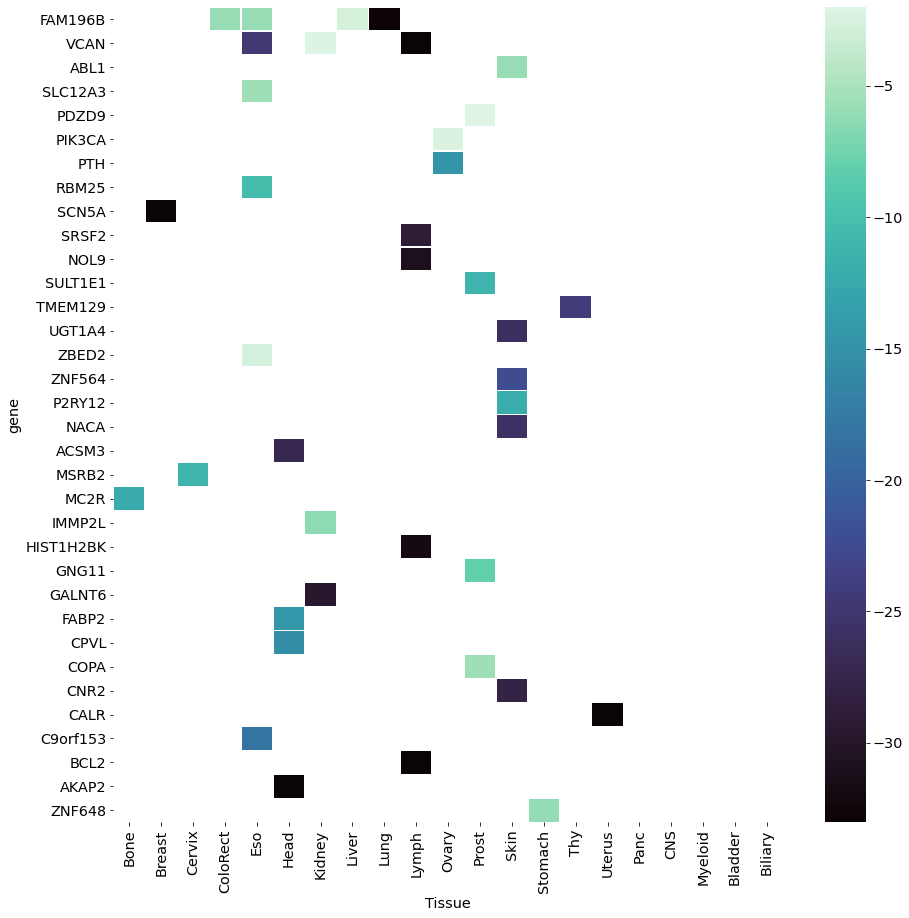

In [4]:
# Plot sort by genes
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(df_pivot_gene,linewidths=.5,cmap="mako")
# # # Plot sort by organs
# fig, ax = plt.subplots(figsize=(15,15))
# ax = sns.heatmap(df_pivot_organ,linewidths=.5,cmap="mako")
plt.savefig('./res/syn_heatmap.pdf')

Non synonymous results

In [6]:
### Read non-synonysmou result
dir_nsout = '/gpfs/group/epo2/default/yur97/gitlab/pcawg-to-mutsigcv/mutsig_out/nsyn/out10212020'
df_nsyn = pd.DataFrame(columns = ['gene','q','Tissue'])
for tumors in os.listdir(dir_nsout):
    for f in os.listdir(os.path.join(dir_nsout,tumors)):
        if f.endswith('sig_genes.txt'):
            df_sig_nsyn = pd.read_csv(os.path.join(dir_nsout,tumors,f),sep = '\t')
            df_sig_true = df_sig_nsyn[df_sig_nsyn['q']<=0.1]
            df_temp = df_sig_true[['gene','q']]
            df_temp['Tissue'] = tumors
    df_nsyn = pd.concat([df_nsyn,df_temp], ignore_index = True)

<ipython-input-6-65c6d28be9fd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Tissue'] = tumors


In [7]:
### Organize non-synonymous dataframe
df_nsyn = df_nsyn[~df_nsyn['gene'].str.startswith('PCDH')]
df_nsyn.loc[df_nsyn['q']==0, 'q'] = 1e-30
df_nsyn['q'] = np.log10(df_nsyn['q'])

### Sort by genes
df_pivot_nsyn = df_nsyn.pivot_table('q', index='gene', columns='Tissue')
for org in org_list:
    if org not in df_pivot_nsyn.columns:
        df_pivot_nsyn[org] = float('NaN')
df_pivot_nsyn['n_sig_gene'] = df_pivot_nsyn.notnull().sum(axis=1)
df_pivot_gene_nsyn = df_pivot_nsyn.sort_values(by = 'n_sig_gene', ascending = False).iloc[:,0:21]

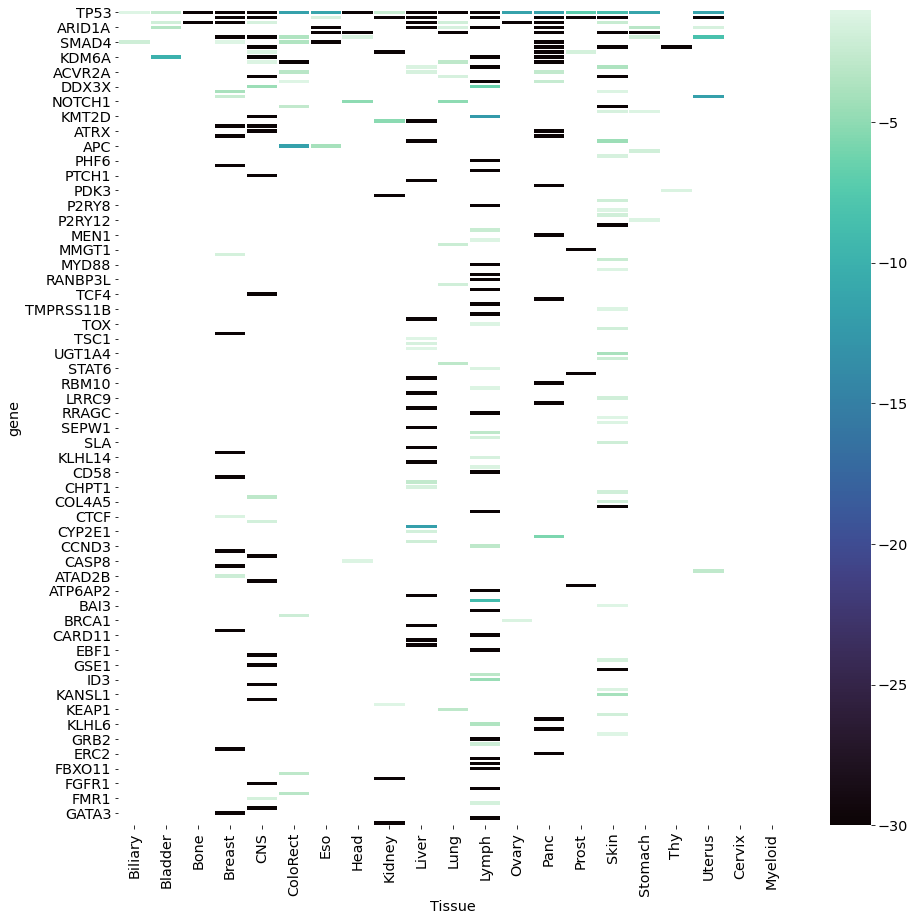

In [7]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(df_pivot_gene_nsyn,linewidths=.5,cmap="mako")

***
### Compare the synonymous and non-synonymous significant gene number

In [9]:
### Read cohort size
df_size = pd.read_csv('../anno_ref/cohort_size.csv')

In [11]:
### Sort by number of organs
# Synonymous 
df_pivot = df_sig.pivot_table('FDR', index='gene', columns='Tissue')
for org in org_list:
    if org not in df_pivot.columns:
        df_pivot[org] = float('NaN')
df_pivot_org = df_pivot.iloc[:,0:21]
df_pivot_org.loc['norg',:]= df_pivot_org.notnull().sum(axis=0)
df_pivot_org = df_pivot_org.sort_values(by='norg', axis =1, ascending = False)

# Non-synonymous
df_pivot_nsyn = df_nsyn.pivot_table('q', index='gene', columns='Tissue')
for org in org_list:
    if org not in df_pivot_nsyn.columns:
        df_pivot_nsyn[org] = float('NaN')
df_pivot_org_nsyn = df_pivot_nsyn.iloc[:,0:21]
df_pivot_org_nsyn.loc['norg',:]= df_pivot_org_nsyn.notnull().sum(axis=0)
df_pivot_org_nsyn = df_pivot_org_nsyn.sort_values(by='norg', axis =1, ascending = False)

In [12]:
# df_pivot_org_nsyn.to_csv('./res/pivot_nsyn_'+today+'.csv')
# df_pivot_org.to_csv('./res/pivot_syn_'+today+'.csv')

In [12]:
### Organize table for plot
nsyn_org = df_pivot_org_nsyn.loc[['norg'],:]
nsyn_org = nsyn_org.transpose()
nsyn_org.reset_index()
nsyn_org['Tissue'] = nsyn_org.index
nsyn_org['Mutation'] = 'Non-synonymous'

syn_org = df_pivot_org.loc[['norg'],:]
syn_org = syn_org.transpose()
syn_org.reset_index()
syn_org['Tissue'] = syn_org.index
syn_org['Mutation'] = 'Synonymous'
# Concat 2 dataframes
df = pd.concat([syn_org,nsyn_org])

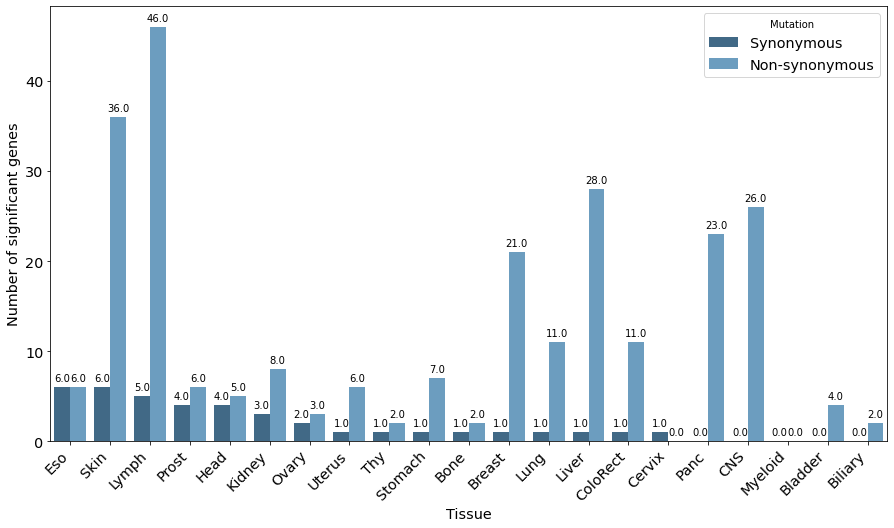

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x="Tissue", y="norg", hue="Mutation", data=df,palette="Blues_d")
ax.set_ylabel('Number of significant genes')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')

In [17]:
df_fdr = pd.read_csv('fdr_all_genes.csv')
df_sig = df_fdr[df_fdr['FDR']<0.01]
df_sig = df_sig[~df_sig['gene'].str.startswith('PCDH')]

In [19]:
df_sig = df_sig[['gene','Tissue','p','FDR']]

In [20]:
df_sig.columns = ['Gene', 'Tumor type', 'p-value', 'Bayesian FDR']

In [24]:
df_sig['p-value'] = round(df_sig['p-value'],5)

<ipython-input-24-ec47c9beb058>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig['p-value'] = round(df_sig['p-value'],5)


In [25]:
df_sig['Bayesian FDR'] = round(df_sig['Bayesian FDR'],5)

<ipython-input-25-e3749a14f26f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig['Bayesian FDR'] = round(df_sig['Bayesian FDR'],5)


(0.0, 1.0, 0.0, 1.0)

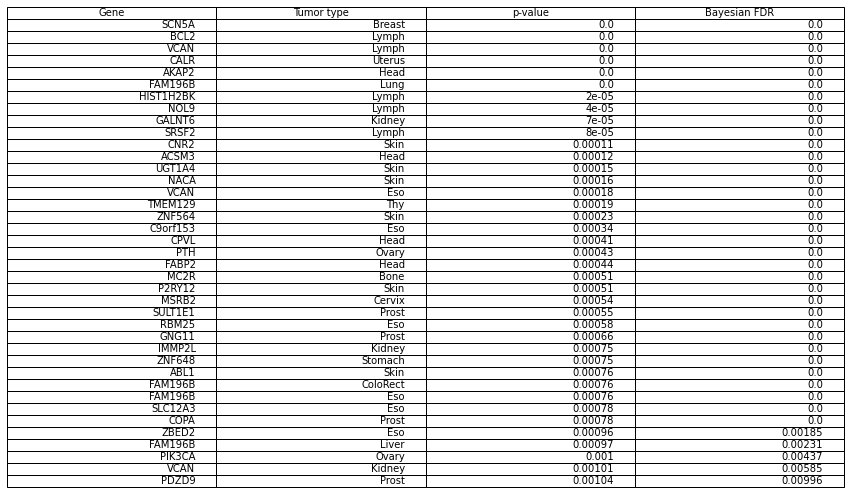

In [26]:
cell_text = []
for row in range(len(df_sig)):
    cell_text.append(df_sig.iloc[row])

plt.table(cellText=cell_text, colLabels=df_sig.columns, loc='center')
plt.axis('off')